In [1]:
#import networkx as nx
import matplotlib.pyplot as plt
import numpy as np
import scipy.stats as sts
import seaborn as sns

%matplotlib inline

#import conviction files
#from conviction_helpers import *
#from conviction_system_logic3 import *
from bonding_curve_eq import *

System initialization

In [2]:
hatch_raise = 100000 # fiat units
hatch_price = .1 #fiat per tokens
theta = .35 #share of funds going to funding pool at launch

R0 = hatch_raise*(1-theta)
F0 = hatch_raise*theta
S0 = hatch_raise/hatch_price

kappa = 2
V0 = invariant(R0,S0,kappa)
P0 = spot_price(R0, V0, kappa)

agent initialization

In [3]:
#number of agents
n= 100

#gain factors
g = sts.expon.rvs(loc=.1, scale=1, size=n)
phat0 = g*F0/S0

#holdings fiat
h = sts.expon.rvs( loc=10,scale=10, size=n)

#holdings tokens
s_dist = sts.expon.rvs(loc=10, scale=10, size=n)
s0 = s_dist/sum(s_dist)*S0

#lambda for revenue process
lam = 20

#phi for exiting funds
phi = .02

In [4]:
params= {
    'kappa': [kappa],
    'lambda': [lam],
    'gains': [g],
    'population':[n],
    'phi': [phi],
    'invariant': [V0]}

In [5]:
initial_conditions = {'holdings': h,
                      'tokens': s0,
                      'supply': S0,
                      'prices': phat0,
                      'funds':F0,
                      'reserve': R0,
                      'spot_price': P0,
                      'action': {}}

In [6]:
initial_conditions

{'action': {},
 'funds': 35000.0,
 'holdings': array([14.88127433, 18.87466608, 19.57784342, 14.63793196, 21.44444536,
        10.317408  , 19.62750331, 12.01878857, 14.2677462 , 16.97842563,
        17.72176759, 14.36539909, 14.6211707 , 15.81277377, 43.90061536,
        32.13775627, 34.48529219, 10.21543366, 10.07163269, 19.75850271,
        12.78694008, 13.45157174, 15.95477221, 23.29108154, 37.35631614,
        39.58434326, 16.12025781, 12.39256593, 30.15218853, 19.4749183 ,
        13.22210379, 23.05457693, 18.71490291, 15.90044881, 26.39627265,
        12.73248402, 22.60235735, 14.70512244, 12.26744585, 12.10522647,
        13.02446565, 13.70205896, 12.64071173, 17.15759214, 10.38946039,
        15.67547335, 17.51918024, 40.69697866, 13.43426017, 22.45919271,
        33.11092485, 10.3702571 , 12.67652359, 22.35003255, 41.30033197,
        19.89817066, 21.58959114, 24.56040609, 11.79517901, 14.46493707,
        10.98525867, 29.4206448 , 11.44259455, 34.82126874, 17.11043099,
     

In [7]:
#change in F (revenue and spending accounted for)
def revenue_process(params, step, sL, s):
    lam = params['lambda']
    rv = sts.expon.rvs(scale=1/lam)
    delF= 1-1/lam+rv
    return({'delF':delF})

In [8]:
def update_funds(params, step, sL, s, _input):
    
    funds = s['funds']*_input['delF']
    
    key = 'funds'
    value = funds
    
    return (key, value)

In [9]:
def update_prices(params, step, sL, s, _input):
    
    g = params['gains']
    phat = g*s['funds']/s['supply']
    
    key = 'prices'
    value = phat
    
    return (key, value)

In [10]:
#change in F (revenue and spending accounted for)
def choose_agent(params, step, sL, s):
    n = params['population']
    rv = np.random.randint(0,n)
    return({'agent':rv})

In [11]:
def agent_action(params, step, sL, s, _input):
    
    a = _input['agent']
    h_a = s['holdings'][a]
    phat_a = s['prices'][a]
    s_a =  s['tokens'][a]
    p = s['spot_price']
    
    if p>phat_a:
        mech = 'burn'
        #solve for burn s.t. p=phat
        #if ha is enough
        amt = 1000 #fill in logic here
        if amt> s_a:
            amt = s_a
        
    else: # p<phat_a:
        mech = 'bond'
        #solve for buy s.t. p=phat
        #if sa is enough
        amt = 1000 #fill in logic here
        if amt> h_a:
            amt = h_a
        
    key = 'action'
    value = {'agent':a, 'mech':mech, 'amt':amt}
    
    return (key, value)

In [12]:
def resolve_action(params, step, sL, s):
    action = s['action']
    a = action['agent']
    amt = action['amt']
    h_a = s['holdings'][a]
    s_a =  s['tokens'][a]
    R = s['reserve']
    S = s['supply']
    F = s['funds']
    V0 = params['invariant']
    
    if action['mech'] == 'bond':
        h_a = h_a-amt
        dS, pbar = mint(amt, R,S, V0, params['kappa'])
        R = R+amt
        S = S+dS
        s_a = s_a+dS
        P = spot_price(R, V0, kappa)
    
    elif action['mech'] == 'burn':
        s_a = s_a-amt
        dR, pbar = withdraw(amt, R,S, V0, params['kappa'])
        R = R-dR
        F = F + params['phi']*dR
        S = S-amt
        h_a = h_a + (1-params['phi'])*dR
        P = spot_price(R, V0, kappa)
    
    return({'F':F, 'S':S, 'R':R,'P':P, 'a':a,'s_a':s_a, 'h_a':h_a})

In [13]:
def update_F(params, step, sL, s, _input):
    
    F = _input['F']
    
    key = 'funds'
    value = F
    
    return (key, value)

def update_S(params, step, sL, s, _input):
    
    S = _input['S']
    
    key = 'supply'
    value = S
    
    return (key, value)

def update_R(params, step, sL, s, _input):
    
    R = _input['R']
    
    key = 'reserve'
    value = R
    
    return (key, value)

def update_P(params, step, sL, s, _input):
    
    P = _input['P']
    
    key = 'spot_price'
    value = P
    
    return (key, value)

def update_holdings(params, step, sL, s, _input):
    
    h_a = _input['h_a']
    a = _input['a']
    
    h = s['holdings']
    h[a] = h_a
    
    key = 'holdings'
    value = h
    
    return (key, value)

def update_tokens(params, step, sL, s, _input):
    
    s_a = _input['s_a']
    a = _input['a']
    
    tokens = s['holdings']
    tokens[a] = s_a
    
    key = 'holdings'
    value = tokens
    
    return (key, value)

In [14]:
# # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # 
# The Partial State Update Blocks
partial_state_update_blocks = [
    { 
        'policies': { 
            #new proposals or new participants
            'random': revenue_process
        },
        'variables': {
            'funds': update_funds,
            'prices': update_prices
        }
    },
    {
      'policies': {
          'random': choose_agent
        },
        'variables': { 
            'action': agent_action, 
        }
    },
    {
      'policies': {
          'act': resolve_action,
        },
        'variables': {
            'funds': update_F, #
            'supply': update_S, 
            'reserve': update_R,
            'spot_price': update_P,
            'holdings': update_holdings,
            'tokens': update_tokens
        }
    }
]

In [15]:
time_periods_per_run = 1000
monte_carlo_runs = 1

from cadCAD.configuration.utils import config_sim
simulation_parameters = config_sim({
    'T': range(time_periods_per_run),
    'N': monte_carlo_runs,
    'M': params
})

In [16]:
from cadCAD.configuration import append_configs
# # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # #
# The configurations above are then packaged into a `Configuration` object
append_configs(
    initial_state=initial_conditions, #dict containing variable names and initial values
    partial_state_update_blocks=partial_state_update_blocks, #dict containing state update functions
    sim_configs=simulation_parameters #dict containing simulation parameters
)

[{'N': 1, 'T': range(0, 1000), 'M': {'kappa': 2, 'lambda': 20, 'gains': array([0.94131832, 0.26859354, 0.38110061, 0.51706446, 0.31427464,
       0.46273963, 1.14456103, 0.82062798, 1.7733353 , 1.68972652,
       1.58607992, 9.5576631 , 1.33215736, 0.34555754, 1.05102631,
       0.87502626, 0.25799865, 1.40254163, 1.00796124, 0.20241237,
       0.22333319, 0.55512391, 1.44572973, 0.82470992, 0.1753408 ,
       0.2960016 , 1.04558639, 0.60526736, 0.20739984, 0.33951077,
       0.18362902, 1.61284755, 2.46998174, 1.30059563, 2.02792526,
       0.56919073, 0.544894  , 0.29838542, 0.50574184, 0.14589808,
       0.30869799, 0.72239021, 2.24171138, 0.36108484, 1.45080069,
       0.34127224, 0.68552167, 2.73614881, 0.33471352, 1.18434063,
       0.9470007 , 0.50593117, 3.07283481, 0.61362619, 0.78991929,
       0.30048405, 1.35454682, 1.04858323, 1.18668756, 1.39095441,
       0.35881591, 0.43675517, 0.61875908, 1.11243611, 0.95473521,
       0.97550478, 0.12143258, 0.72174688, 0.99402087, 1.

In [17]:
from tabulate import tabulate
from cadCAD.engine import ExecutionMode, ExecutionContext, Executor
from cadCAD import configs
import pandas as pd

exec_mode = ExecutionMode()
multi_proc_ctx = ExecutionContext(context=exec_mode.multi_proc)
run = Executor(exec_context=multi_proc_ctx, configs=configs)

In [18]:
i = 0
verbose = False
results = {}
for raw_result, tensor_field in run.execute():
    result = pd.DataFrame(raw_result)
    if verbose:
        print()
        print(f"Tensor Field: {type(tensor_field)}")
        print(tabulate(tensor_field, headers='keys', tablefmt='psql'))
        print(f"Output: {type(result)}")
        print(tabulate(result, headers='keys', tablefmt='psql'))
        print()
    results[i] = {}
    results[i]['result'] = result
    results[i]['simulation_parameters'] = simulation_parameters[i]
    i += 1
    


                            __________   ____ 
          ________ __ _____/ ____/   |  / __ \
         / ___/ __` / __  / /   / /| | / / / /
        / /__/ /_/ / /_/ / /___/ ___ |/ /_/ / 
        \___/\__,_/\__,_/\____/_/  |_/_____/  
        by BlockScience
        
Execution Mode: multi_proc: [<cadCAD.configuration.Configuration object at 0x1a1bc624e0>, <cadCAD.configuration.Configuration object at 0x1a1bcc9f60>]
Configurations: [<cadCAD.configuration.Configuration object at 0x1a1bc624e0>, <cadCAD.configuration.Configuration object at 0x1a1bcc9f60>]


In [19]:
experiment_index = 0
df = results[experiment_index]['result']

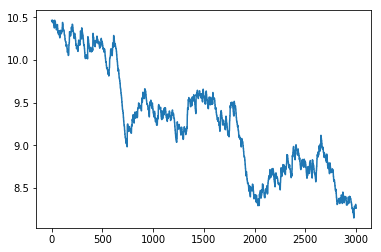

In [20]:
df.funds.apply(np.log).plot()

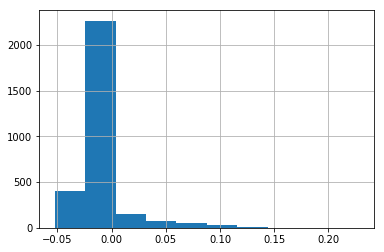

In [21]:
(df.funds.diff()/df.funds).hist()

In [22]:
rdf = df[df.substep == 3]

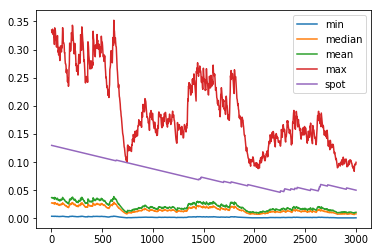

In [29]:
rdf.prices.apply(np.min).plot()
rdf.prices.apply(np.median).plot()
rdf.prices.apply(np.mean).plot()
rdf.prices.apply(np.max).plot()
rdf.spot_price.plot()
plt.legend(['min', 'median','mean','max', 'spot'])

In [24]:
rdf.action

3       {'agent': 17, 'mech': 'burn', 'amt': 1000}
6       {'agent': 36, 'mech': 'burn', 'amt': 1000}
9       {'agent': 83, 'mech': 'burn', 'amt': 1000}
12      {'agent': 19, 'mech': 'burn', 'amt': 1000}
15      {'agent': 70, 'mech': 'burn', 'amt': 1000}
18      {'agent': 92, 'mech': 'burn', 'amt': 1000}
21       {'agent': 3, 'mech': 'burn', 'amt': 1000}
24       {'agent': 6, 'mech': 'burn', 'amt': 1000}
27      {'agent': 57, 'mech': 'burn', 'amt': 1000}
30      {'agent': 60, 'mech': 'burn', 'amt': 1000}
33      {'agent': 63, 'mech': 'burn', 'amt': 1000}
36      {'agent': 10, 'mech': 'burn', 'amt': 1000}
39      {'agent': 20, 'mech': 'burn', 'amt': 1000}
42      {'agent': 93, 'mech': 'burn', 'amt': 1000}
45      {'agent': 85, 'mech': 'burn', 'amt': 1000}
48      {'agent': 52, 'mech': 'burn', 'amt': 1000}
51       {'agent': 1, 'mech': 'burn', 'amt': 1000}
54      {'agent': 17, 'mech': 'burn', 'amt': 1000}
57      {'agent': 18, 'mech': 'burn', 'amt': 1000}
60      {'agent': 48, 'mech': '

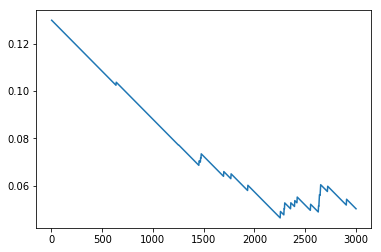

In [25]:
rdf.spot_price.plot()